Import Library & Load Data

In [182]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from statsmodels.regression.linear_model import GLSAR

# -----------------------------------------------------
# 1. LOAD DATA
# -----------------------------------------------------
df = pd.read_excel("BBCA_Financial_Data.xlsx")

display(df.head())


,YEAR,STOCK_PRICE,NET_INCOME,NIM,ROE,DEBT_TO_EQUITY,MARKET_INDEX_RETURN
0,2024,9800,76962905,0.0583,0.2456,4.56,-0.0325
1,2023,9400,70452210,0.0554,0.2349,4.82,0.0616
2,2022,8550,60192381,0.0534,0.2170,4.95,0.0409
3,2021,7300,52786923,0.0510,0.1825,5.03,0.1008
4,2020,6770,51090899,0.0570,0.1654,4.80,-0.0511


Clean Data

In [183]:
# CLEAN BIG NUMBERS 
def clean_big_number(x):
    if isinstance(x, str):
        x = x.replace(",", "")
        try:
            return float(x)
        except:
            return x
    return x


# Apply cleaning
for col in df.columns:
    df[col] = df[col].apply(clean_big_number)

# Formatting helper 
def format_TBM(x): 
    if pd.isna(x): 
        return "" 
    if x >= 1e6: 
        return f"{x/1e6:.1f}".replace(".", ",") + "T" 
    return str(x)

# Create formatted version
formatted_df = df.copy()

for col in formatted_df.columns:
    if col in ["NET_INCOME", "TOTAL_ASSETS", "STOCK_PRICE"]:  
        formatted_df[col] = formatted_df[col].apply(format_TBM)


formatted_df

,YEAR,STOCK_PRICE,NET_INCOME,NIM,ROE,DEBT_TO_EQUITY,MARKET_INDEX_RETURN
0,2024,9800,"77,0T",0.0583,0.2456,4.56,-0.0325
1,2023,9400,"70,5T",0.0554,0.2349,4.82,0.0616
2,2022,8550,"60,2T",0.0534,0.2170,4.95,0.0409
3,2021,7300,"52,8T",0.0510,0.1825,5.03,0.1008
4,2020,6770,"51,1T",0.0570,0.1654,4.80,-0.0511
5,2019,6660,"47,4T",0.0624,0.1797,4.71,0.0162
6,2018,5200,"25,9T",0.0610,0.1740,4.80,-0.0247
7,2017,4300,"23,3T",0.0620,0.1774,4.83,0.2018
8,2016,3260,"20,6T",0.0680,0.1764,5.05,0.1532
9,2015,2700,"18,7T",0.0710,0.1866,5.04,-0.1213


Summary Statistics Table

In [184]:
# Helper formatting untuk angka biasa (tanpa persen)
def format_number(x):
    if pd.isna(x):
        return x
    return f"{x:,.2f}"

# Summary statistics function
def summary_statistics(df):
    summary = pd.DataFrame()
    summary["N"] = df.count()
    summary["Mean"] = df.mean(numeric_only=True)
    summary["Std Dev"] = df.std(numeric_only=True)
    summary["Min"] = df.min(numeric_only=True)
    summary["Max"] = df.max(numeric_only=True)
    summary["Missing"] = df.isna().sum()
    summary["Outliers"] = df.apply(
        lambda x: ((x < (x.mean() - 3*x.std())) | (x > (x.mean() + 3*x.std()))).sum()
    )
    return summary

# Remove YEAR
numeric_df = df.drop(columns=["YEAR"])

# Hitung summary
summary_table = summary_statistics(numeric_df)

# Format semua kolom numerik
formatted = summary_table.copy()
for col in ["Mean", "Std Dev", "Min", "Max"]:
    formatted[col] = formatted[col].apply(format_number)

# Tampilkan summary
display(formatted)

,N,Mean,Std Dev,Min,Max,Missing,Outliers
STOCK_PRICE,14,"5,212.86","2,836.83","1,960.00","9,800.00",0,0
NET_INCOME,14,"35,875,650.14","23,032,568.17","10,729,190.00","76,962,905.00",0,0
NIM,14,0.06,0.01,0.05,0.07,0,0
ROE,14,0.19,0.02,0.17,0.25,0,0
DEBT_TO_EQUITY,14,4.93,0.19,4.56,5.30,0,0
MARKET_INDEX_RETURN,14,0.05,0.10,-0.12,0.22,0,0


Regression Analysis

In [185]:
# Log-transform STOCK_PRICE untuk memperbaiki linearity
df['LOG_STOCK_PRICE'] = np.log(df['STOCK_PRICE'])

# Pilih dependent dan independent variables
y = df['LOG_STOCK_PRICE']
X = df[["NET_INCOME","NIM","ROE","DEBT_TO_EQUITY","MARKET_INDEX_RETURN"]]
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Ambil hasil summary
results = model.summary2().tables[1]  # tabel koefisien

# Tambahkan kolom Significance
def significance(p):
    if p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    elif p < 0.1:
        return "†"
    else:
        return "NS"

results["Significance"] = results["P>|t|"].apply(significance)

# Tambahkan 95% Confidence Interval dalam format [lower, upper]
results["95% CI"] = results.apply(lambda row: f"[{row['[0.025']:.2f}, {row['0.975]']:.2f}]", axis=1)

# Format kolom agar mirip contoh
results = results.rename(columns={
    "Coef.": "Coefficient (β)",
    "Std.Err.": "Std Error",
    "t": "t-value",
    "P>|t|": "p-value"
})

# Tampilkan hasil
results[["Coefficient (β)", "Std Error", "t-value", "p-value", "95% CI", "Significance"]]

,Coefficient (β),Std Error,t-value,p-value,95% CI,Significance
const,1.208964e+01,2.624138e+00,4.607091,0.001739,"[6.04, 18.14]",**
NET_INCOME,2.216219e-08,6.100698e-09,3.632731,0.006659,"[0.00, 0.00]",**
NIM,-1.203987e+01,1.432502e+01,-0.840478,0.425046,"[-45.07, 20.99]",NS
ROE,-4.443674e+00,3.042618e+00,-1.460477,0.182288,"[-11.46, 2.57]",NS
DEBT_TO_EQUITY,-5.897461e-01,4.186601e-01,-1.408651,0.196597,"[-1.56, 0.38]",NS
MARKET_INDEX_RETURN,3.005398e-01,5.054018e-01,0.594655,0.568507,"[-0.86, 1.47]",NS


Model Evaluation

Linearity Check

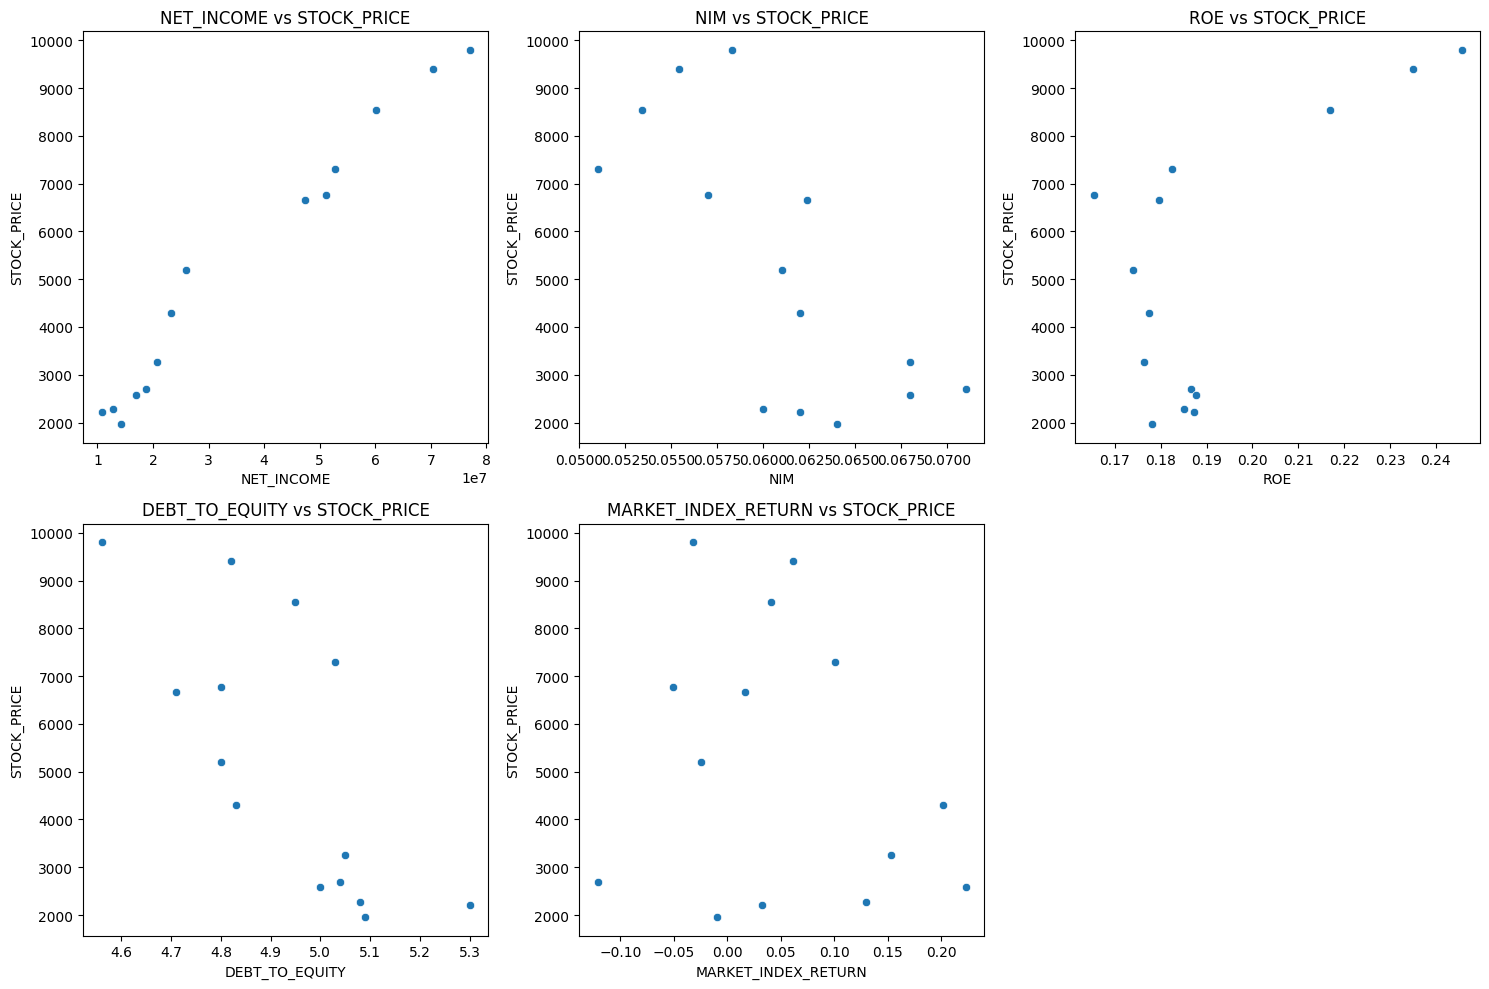

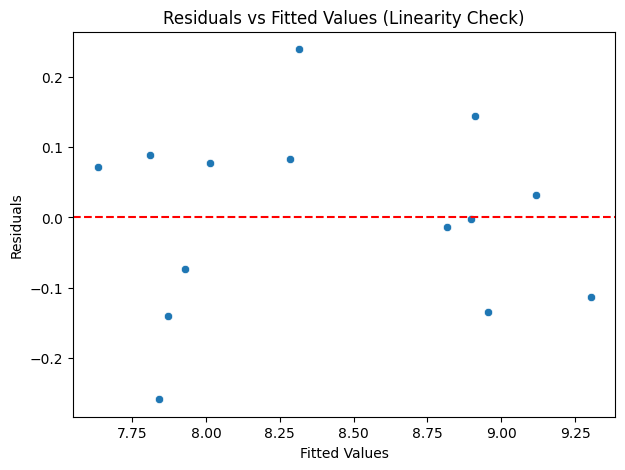

In [192]:
# Pastikan residual dan fitted values sudah dihitung dari model OLS
residuals = model.resid
fitted = model.fittedvalues

# -----------------------------------------------------
# 1. Scatter Plot Each Predictor vs Dependent Variable
# -----------------------------------------------------
predictors = ["NET_INCOME", "NIM", "ROE", "DEBT_TO_EQUITY", "MARKET_INDEX_RETURN"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(predictors, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[col], y=df["STOCK_PRICE"])
    plt.xlabel(col)
    plt.ylabel("STOCK_PRICE")
    plt.title(f"{col} vs STOCK_PRICE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 2. Residuals vs Fitted Plot
# -----------------------------------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Linearity Check)")
plt.show()

In [191]:
# 6. MODEL EVALUATION
# -----------------------------------------------------

# ----- 1. Model Fit Metrics -----
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj
f_stat = model.fvalue
f_pvalue = model.f_pvalue

# RMSE
rmse = np.sqrt(model.mse_resid)

# ----- 2. Regression Assumptions -----
residuals = model.resid
fitted = model.fittedvalues

# Normality – Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(residuals)

# Homoscedasticity – Breusch-Pagan
bp_test = het_breuschpagan(residuals, model.model.exog)
bp_pvalue = bp_test[1]

# Independence – Durbin-Watson
dw_stat = durbin_watson(residuals)

# Multicollinearity – VIF
vif_df = pd.DataFrame({
    "Variable": [var for var in X.columns if var.lower() != "const"],
    "VIF": [variance_inflation_factor(X.values, i)
            for i, var in enumerate(X.columns) if var.lower() != "const"]
})

# Influential observations – Cook's Distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
max_cooks = cooks_d.max()

# -----------------------------------------------------
# BUILD ASSUMPTION RESULTS TABLE
# -----------------------------------------------------

assumption_results = pd.DataFrame({
    "Assumption": [
        "Linearity",
        "Normality",
        "Homoscedasticity",
        "Independence",
        "Multicollinearity",
        "Influential Observations"
    ],
    "Test": [
        "Residual vs Fitted",
        f"Shapiro-Wilk (p = {shapiro_p:.3f})",
        f"Breusch-Pagan (p = {bp_pvalue:.3f})",
        f"Durbin-Watson = {dw_stat:.2f}",
        "VIF < 10M?",
        f"Max Cook's D = {max_cooks:.2f}"
    ],
    "Status": [
        "Check visually",
        "✓ Met" if shapiro_p > 0.05 else "✗ Not Met",
        "✓ Met" if bp_pvalue > 0.05 else "✗ Not Met",
        "✓ Met" if 1.5 <= dw_stat <= 2.5 else "✗ Possible autocorrelation",
        "✓ Met" if vif_df["VIF"].max() < 10 else "✗ High multicollinearity",
        "✓ Met" if max_cooks < 1 else "✗ Influential points detected"
    ]
})

# -----------------------------------------------------
# MODEL FIT SUMMARY TABLE
# -----------------------------------------------------

model_fit = pd.DataFrame({
    "Metric": [
        "R-squared",
        "Adjusted R-squared",
        "F-statistic",
        "F-test p-value",
        "RMSE",
        "Residual Std Error"
    ],
    "Value": [
        f"{r_squared:.3f}",
        f"{adj_r_squared:.3f}",
        f"{f_stat:.2f}",
        f"{f_pvalue:.4f}",
        f"{rmse:.2f}",
        f"{np.sqrt(model.scale):.2f}"
    ]
})

# -----------------------------------------------------
# DISPLAY OUTPUT
# -----------------------------------------------------

print("=== MODEL FIT SUMMARY ===")
display(model_fit)

print("\n=== ASSUMPTION TEST RESULTS ===")
display(assumption_results)

print("\n=== VIF TABLE (Multicollinearity Check) ===")
display(vif_df)

=== MODEL FIT SUMMARY ===


,Metric,Value
0,R-squared,0.949
1,Adjusted R-squared,0.917
2,F-statistic,29.69
3,F-test p-value,0.0001
4,RMSE,0.17
5,Residual Std Error,0.17



=== ASSUMPTION TEST RESULTS ===


,Assumption,Test,Status
0,Linearity,Residual vs Fitted,Check visually
1,Normality,Shapiro-Wilk (p = 0.947),✓ Met
2,Homoscedasticity,Breusch-Pagan (p = 0.229),✓ Met
3,Independence,Durbin-Watson = 1.30,✗ Possible autocorrelation
4,Multicollinearity,VIF < 10M?,✓ Met
5,Influential Observations,Max Cook's D = 0.51,✓ Met



=== VIF TABLE (Multicollinearity Check) ===


,Variable,VIF
0,NET_INCOME,8.996649
1,NIM,3.052183
2,ROE,2.390520
3,DEBT_TO_EQUITY,2.874462
4,MARKET_INDEX_RETURN,1.160474
